# Age Classifier

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from collections import defaultdict
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
path = '../data/face_age'
width = 180
height = 180
train = True

In [3]:
def load_image(filename: str, size: int) -> np.array:
    """Loads and resizes the image."""
    image = Image.open(filename)
    resized_image = image.resize(size)
    return np.array(resized_image)

In [4]:
images = defaultdict()

for subfolder in os.listdir(path):
    images_per_folder = glob.glob(f'{path}/{subfolder}/*.png')
    number_of_images = len(images_per_folder)
    key = int(subfolder.lstrip('0'))
    tmp = []

    if number_of_images > 175:
        for filename in images_per_folder[:175]:
            image = load_image(filename, size=(width, height))
            tmp.append(image)
    else:
        for filename in images_per_folder:
            image = load_image(filename, size=(width, height))
            tmp.append(image)

    images[key] = tmp
    tmp = []

In [5]:
child = []
young_adult = []
adult = []
senior = []

for key, value in images.items():
    if key <= 16:
        child += value
    elif 16 < key <= 30:
        young_adult += value
    elif 30 < key <= 60:
        adult += value
    else:
        senior += value

data = defaultdict()
data['child'] = child
data['young_adult'] = young_adult
data['adult'] = adult
data['senior'] = senior

In [6]:
X = np.array([])
y = np.array([])
labels = {
    'child': 0,
    'young_adult': 1,
    'adult': 2,
    'senior': 3,
}

for key, value in data.items():
    n = len(value)
    X = np.append(X, value)
    y = np.append(y, [labels[key]] * n)

X = X.reshape(-1, width, height, 3)

In [7]:
test_size = ceil(len(X) * 0.1)

# Split Data
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=test_size, 
                                                  random_state=42)

In [8]:
shift = 0.1
datagen = ImageDataGenerator(rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=shift,
                             width_shift_range=shift)

datagen.fit(x_train)

In [9]:
epochs = 50
batch_size = 64

print("X_train shape: " + str(x_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(x_test.shape))
print("Y_test shape: " + str(y_test.shape))
print("X_val shape: " + str(x_val.shape))
print("Y_val shape: " + str(y_val.shape))

X_train shape: (6494, 180, 180, 3)
Y_train shape: (6494,)
X_test shape: (812, 180, 180, 3)
Y_test shape: (812,)
X_val shape: (812, 180, 180, 3)
Y_val shape: (812,)


In [10]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(width, height, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax'),
])

model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [11]:
train_progress = None

if train:
    early_stopping = EarlyStopping(monitor='accuracy',
                                   min_delta=0.00005,
                                   patience=20,
                                   verbose=2,
                                   restore_best_weights=True)
    
    train_progress = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
                               epochs=epochs, 
                               steps_per_epoch=len(x_train) // batch_size, 
                               validation_data=(x_val, y_val), 
                               verbose=2,
                               callbacks=[early_stopping])
    
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

Epoch 1/120
101/101 - 75s - loss: 1.3480 - accuracy: 0.3756 - val_loss: 1.1996 - val_accuracy: 0.4360
Epoch 2/120
101/101 - 78s - loss: 1.1769 - accuracy: 0.4737 - val_loss: 1.0758 - val_accuracy: 0.5320
Epoch 3/120
101/101 - 61s - loss: 1.0999 - accuracy: 0.5196 - val_loss: 0.9531 - val_accuracy: 0.6108
Epoch 4/120
101/101 - 58s - loss: 1.0615 - accuracy: 0.5415 - val_loss: 0.9270 - val_accuracy: 0.6121
Epoch 5/120
101/101 - 54s - loss: 1.0058 - accuracy: 0.5695 - val_loss: 0.9180 - val_accuracy: 0.6145
Epoch 6/120
101/101 - 60s - loss: 0.9907 - accuracy: 0.5723 - val_loss: 0.8806 - val_accuracy: 0.6490
Epoch 7/120
101/101 - 56s - loss: 0.9611 - accuracy: 0.5952 - val_loss: 0.8590 - val_accuracy: 0.6552
Epoch 8/120
101/101 - 56s - loss: 0.9213 - accuracy: 0.6137 - val_loss: 0.8333 - val_accuracy: 0.6638
Epoch 9/120
101/101 - 56s - loss: 0.9074 - accuracy: 0.6170 - val_loss: 0.8565 - val_accuracy: 0.6478
Epoch 10/120
101/101 - 53s - loss: 0.8884 - accuracy: 0.6272 - val_loss: 0.7988 - 

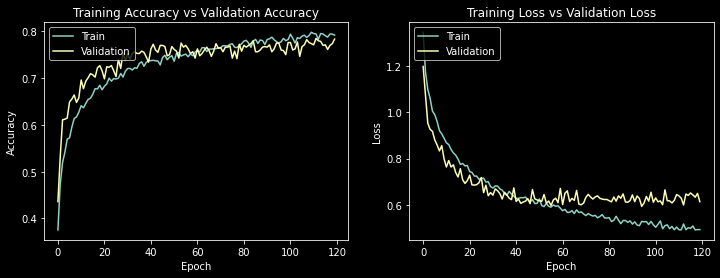

In [12]:
if train_progress:
    fig, ax = plt.subplots(1, 2)
    train_acc = train_progress.history['accuracy']
    train_loss = train_progress.history['loss']
    fig.set_size_inches(12, 4)

    ax[0].plot(train_progress.history['accuracy'])
    ax[0].plot(train_progress.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    ax[1].plot(train_progress.history['loss'])
    ax[1].plot(train_progress.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()